In [2]:
import json

In [14]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import onmt.io


In [13]:
import torch.nn.functional as F

In [119]:
from IPython.display import Image, HTML

In [5]:
images = json.load(open('/Users/kcarnold/src/ImageCaptioning.pytorch/data/dataset_coco.json'))['images']

In [162]:
for img in images:
    img['all_captions'] = '\n'.join(sent['raw'].replace('\n', ' ') for sent in img['sentences'])

In [159]:
images[0]

{'all_captions': 'Three women and a man are sitting at a bar\nThree women and a man are sitting at a bar\nThree women and a man are sitting at a bar\nThree women and a man are sitting at a bar\nThree women and a man are sitting at a bar',
 'cocoid': 391895,
 'filename': 'COCO_val2014_000000391895.jpg',
 'filepath': 'val2014',
 'imgid': 0,
 'sentences': [{'imgid': 0,
   'raw': 'A man with a red helmet on a small moped on a dirt road. ',
   'sentid': 770337,
   'tokens': ['a',
    'man',
    'with',
    'a',
    'red',
    'helmet',
    'on',
    'a',
    'small',
    'moped',
    'on',
    'a',
    'dirt',
    'road']},
  {'imgid': 0,
   'raw': 'Man riding a motor bike on a dirt road on the countryside.',
   'sentid': 771687,
   'tokens': ['man',
    'riding',
    'a',
    'motor',
    'bike',
    'on',
    'a',
    'dirt',
    'road',
    'on',
    'the',
    'countryside']},
  {'imgid': 0,
   'raw': 'A man riding on the back of a motorcycle.',
   'sentid': 772707,
   'tokens': ['a',
 

In [163]:
import re

In [165]:
[img['all_captions'] for img in images if re.search(r'korean.*air', img['all_captions'].lower())][:10]

['two large air planes on a run way\nAirplanes sit facing away from each other in front of an airport.\nTwo Korean Air jets parked on a runway next to a terminal.\nTwo korean airlines commercial airliners on the tarmac.\nTwo airplanes facing the opposite direction on the runway. ',
 'Three Korean Air jets lined up at the airport terminal\nThree airplanes are parked beside an airport building.\nThere are a few airplanes parked on the runway.\nAirliners parked at gates of an airport, with jetways.\nA couple of blue planes are parked at some terminals',
 'a blue korean air airplane sitting on the track\nA Korean Air plane riding down an airport runway.\nA light blue Korean Air plane on the runway.\nAn airplane from Korean Air is painted in blue.\nthere is a very large blue plane at this airport']

In [6]:
len(images)

123287

In [7]:
images[0]

{'cocoid': 391895,
 'filename': 'COCO_val2014_000000391895.jpg',
 'filepath': 'val2014',
 'imgid': 0,
 'sentences': [{'imgid': 0,
   'raw': 'A man with a red helmet on a small moped on a dirt road. ',
   'sentid': 770337,
   'tokens': ['a',
    'man',
    'with',
    'a',
    'red',
    'helmet',
    'on',
    'a',
    'small',
    'moped',
    'on',
    'a',
    'dirt',
    'road']},
  {'imgid': 0,
   'raw': 'Man riding a motor bike on a dirt road on the countryside.',
   'sentid': 771687,
   'tokens': ['man',
    'riding',
    'a',
    'motor',
    'bike',
    'on',
    'a',
    'dirt',
    'road',
    'on',
    'the',
    'countryside']},
  {'imgid': 0,
   'raw': 'A man riding on the back of a motorcycle.',
   'sentid': 772707,
   'tokens': ['a',
    'man',
    'riding',
    'on',
    'the',
    'back',
    'of',
    'a',
    'motorcycle']},
  {'imgid': 0,
   'raw': 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a backgro

In [8]:
valid_images = [img for img in images if img['split'] == 'val']
len(valid_images)

5000

A few images have 6 sentences rather than the normal 5. We'll ignore that.

In [9]:
[(img['cocoid'], len(img['sentences'])) for img in valid_images if len(img['sentences']) != 5]

[(96493, 6),
 (510643, 6),
 (92771, 6),
 (204311, 6),
 (567315, 6),
 (100008, 6),
 (320428, 6),
 (449312, 6),
 (459032, 6),
 (216369, 6)]

In [10]:
val_imgids = [img['cocoid'] for img in valid_images for sent in img['sentences']]
val_caps = [sent['tokens'] for img in valid_images for sent in img['sentences']]
len(val_caps)

25010

In [153]:
[img['cocoid'] for img in images if img['imgid'] == 2529]

[395402]

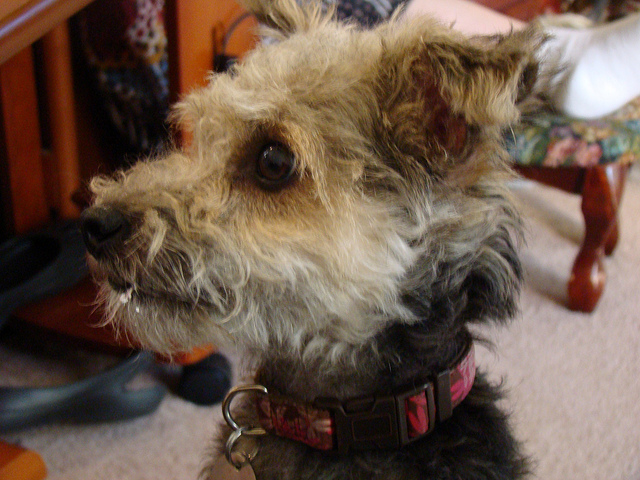

In [154]:
show_coco(395402)

# Use the OpenNMT models to score likelihoods.

In [1]:
from textrec import onmt_model_2
from textrec.paths import paths

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


In [11]:
image_idx2id = [int(line.strip()) for line in open(paths.models / 'idx2id.txt')]
image_id2idx = {image_id: idx for idx, image_id in enumerate(image_idx2id)}

First, compute the context-free likelihood of each caption.

In [12]:
coco_lm = onmt_model_2.models['coco_lm']

DANGER: `model.decoder` can mutate `decoder_state`!

In [22]:
lm_src = Variable(torch.LongTensor([coco_lm.fields['src'].vocab.stoi['.']]).unsqueeze(1).unsqueeze(1), volatile=True)
lm_tgt_vocab = coco_lm.fields['tgt'].vocab

In [48]:
enc_final, memory_bank = coco_lm.model.encoder(src)

In [23]:
def eval_logprob(model, src, encoder_final, memory_bank, tgt_tokens, tgt_vocab):
    decoder_state = coco_lm.model.decoder.init_decoder_state(src, memory_bank=memory_bank, encoder_final=encoder_final)
    tgt_tokens = [onmt.io.BOS_WORD] + tgt_tokens + [onmt.io.EOS_WORD]
    tgt = Variable(torch.LongTensor([tgt_vocab.stoi[tok] for tok in tgt_tokens]).unsqueeze(1).unsqueeze(1))
    dec_out, dec_states, attn = model.decoder(tgt[:-1], memory_bank, decoder_state)
    logits = model.generator(dec_out)
    return F.nll_loss(logits.squeeze(1), tgt[1:].squeeze(1).squeeze(1), reduce=True).data[0]

encoder_final, memory_bank = coco_lm.model.encoder(lm_src)
for cap in val_caps[:5]:
    print(eval_logprob(coco_lm.model, lm_src, encoder_final, memory_bank, cap, lm_tgt_vocab))

4.055610179901123
1.9828158617019653
4.326562404632568
3.957759141921997
2.8188583850860596


In [24]:
%timeit eval_logprob(coco_lm.model, lm_src, encoder_final, memory_bank, cap, lm_tgt_vocab)

129 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
len(cap)

10

In [91]:
def eval_logprob_batched(model, src, tgt_field, encoder_final, memory_bank, batch, divide_by_length=True):
    batch_size = len(batch)

    # We need to redo this each time because decoder mutates the state that's passed to it :(
    decoder_state = coco_lm.model.decoder.init_decoder_state(src, memory_bank=memory_bank, encoder_final=encoder_final)
    decoder_state.repeat_beam_size_times(batch_size)
    memory_bank = memory_bank.repeat(1, batch_size, 1)

    # "process" handles padding and numericalization
    tgt = tgt_field.process(batch, device=-1, train=False)
    pad_idx = tgt_field.vocab.stoi[tgt_field.pad_token]
    
    # Decoder wants an extra dim for extra features.
    dec_out, dec_states, attn = model.decoder(tgt[:-1].unsqueeze(2), memory_bank, decoder_state)
    logits = model.generator(dec_out).contiguous()
    seq_len, batch_size_2, num_vocab = logits.shape
    assert batch_size == batch_size_2
    losses = F.nll_loss(logits.view(seq_len * batch_size, num_vocab), tgt[1:].view(seq_len * batch_size), reduce=False)
    mask = tgt[1:].eq(pad_idx)
    losses = losses.view(seq_len, batch_size).masked_fill(mask, 0).data.sum(0)
    if divide_by_length:
        length = (~mask.data).long().sum(0)
        return losses / length.float()
    else:
        return losses

encoder_final, memory_bank = coco_lm.model.encoder(lm_src)
batch_size = 32
unconditional_losses = eval_logprob_batched(coco_lm.model, lm_src, coco_lm.fields['tgt'], encoder_final, memory_bank, val_caps[:batch_size]).numpy()
unconditional_losses

array([4.05561  , 1.9828162, 4.3265624, 3.9577591, 2.8188581, 2.1887002,
       2.9275367, 3.178268 , 3.394708 , 3.3064091, 2.8171813, 3.260916 ,
       2.3935277, 3.4049525, 3.1746356, 1.4956913, 3.4236114, 6.401656 ,
       2.3428607, 6.3635745, 3.0610476, 4.6592226, 4.3822927, 3.0525162,
       3.3139853, 2.8301854, 1.9576231, 2.3530643, 1.6457199, 2.0004718,
       1.5807973, 1.2306131], dtype=float32)

In [33]:
%timeit losses = eval_logprob_batched(coco_lm.model, lm_src, coco_lm.fields['tgt'], encoder_final, memory_bank, val_caps[:batch_size])

941 ms ± 34.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
129 * batch_size / 941

4.386822529224229

In [35]:
import tqdm
import toolz

In [36]:
len(val_caps)

25010

In [99]:
batches = list(toolz.partition_all(32, val_caps))

In [103]:
lm_encoder_final, lm_memory_bank = coco_lm.model.encoder(lm_src)
unconditional_logprobs_batched = [
    eval_logprob_batched(coco_lm.model, lm_src, coco_lm.fields['tgt'], lm_encoder_final, lm_memory_bank, batch, divide_by_length=False).numpy()
    for batch in tqdm.tqdm_notebook(batches)
]

HBox(children=(IntProgress(value=0, max=782), HTML(value='')))

In [106]:
unconditional_logprobs = np.array(list(toolz.concat(unconditional_logprobs_batched)))

In [107]:
len(unconditional_logprobs)

25010

In [121]:
df = pd.DataFrame(dict(caps=[' '.join(toks) for toks in val_caps], num_words=[len(toks) for toks in val_caps], unconditional_logprobs=unconditional_logprobs))
df['per_word'] = df['unconditional_logprobs'] / df['num_words']

In [122]:
df.sort_values('per_word')
#df.sort_values('unconditional_logprobs')

,caps,num_words,unconditional_logprobs,per_word
12953,a close up of a plate of food with broccoli,10,8.451857,0.845186
1610,a close up of a plate of food with broccoli,10,8.451857,0.845186
5467,a close up of a plate of food with broccoli,10,8.451857,0.845186
22004,a close up of a plate of food with broccoli,10,8.451857,0.845186
13365,a close up of a street sign with trees in the background,12,10.782018,0.898501
14927,a person riding a skate board at a skate park,10,9.050190,0.905019
10985,a person riding a skate board at a skate park,10,9.050190,0.905019
9188,a person riding a skate board at a skate park,10,9.050190,0.905019
19390,a person riding a skate board at a skate park,10,9.050190,0.905019
18864,a person riding a surf board on a wave,9,8.256473,0.917386


In [139]:
# query = 'a smiling man eating matzah at a passover seder'
# query = 'a wine taster carefully examining wine samples kept in glasses'
query = 'many mannequin heads feature fashionable scarves and hats'
val_imgids[[' '.join(toks) for toks in val_caps].index(query)]

328921

In [124]:
val_imgids[13668]

16382

In [134]:
imgid_to_img[213904]

{'cocoid': 213904,
 'filename': 'COCO_val2014_000000213904.jpg',
 'filepath': 'val2014',
 'imgid': 31740,
 'sentences': [{'imgid': 31740,
   'raw': 'A man holding a glass of wine while sitting at a table filled with wine glasses.',
   'sentid': 110270,
   'tokens': ['a',
    'man',
    'holding',
    'a',
    'glass',
    'of',
    'wine',
    'while',
    'sitting',
    'at',
    'a',
    'table',
    'filled',
    'with',
    'wine',
    'glasses']},
  {'imgid': 31740,
   'raw': 'Man in coat testing wine aromas and bouquet.',
   'sentid': 121538,
   'tokens': ['man',
    'in',
    'coat',
    'testing',
    'wine',
    'aromas',
    'and',
    'bouquet']},
  {'imgid': 31740,
   'raw': 'A man is surrounded by many whine glasses',
   'sentid': 122534,
   'tokens': ['a',
    'man',
    'is',
    'surrounded',
    'by',
    'many',
    'whine',
    'glasses']},
  {'imgid': 31740,
   'raw': 'A man who is at a wine tasting event.',
   'sentid': 124370,
   'tokens': ['a', 'man', 'who', 'is'

In [37]:
coco_cap = onmt_model_2.models['coco_cap']

In [40]:
val_imgids[0]

184613

In [42]:
lm_src

Variable containing:
(0 ,.,.) = 
  2
[torch.LongTensor of size 1x1x1]

In [45]:
cap_src = Variable(torch.LongTensor([image_id2idx[val_imgids[0]]]).view(1,1,1), volatile=True)
cap_src

Variable containing:
(0 ,.,.) = 
  1.1816e+05
[torch.LongTensor of size 1x1x1]

In [ ]:
import h5py
f = h5py.File(str(paths.models / "feats_by_imgid.h5"))

In [56]:
def load_vecs(imgids, num_objs=36, feature_dim=2048):
    batch_size = len(imgids)
    vecs = np.empty((num_objs, batch_size, feature_dim))
    for i, idx in enumerate(imgids):
        vecs[:, i, :] = f[str(idx)][:]
    return Variable(torch.FloatTensor(vecs), volatile=True)


In [60]:
def encode_vecs(self, vecs):
    # vecs: objs x batch_size x feature_dim
    mean_feature = torch.mean(vecs, dim=0)  # batch_size x feature_dim

    # Construct the hidden and cell states.
    hidden_state = F.tanh(self.init_hidden(mean_feature))
    cell_state = F.tanh(self.init_cell(mean_feature))
    # hidden_state: batch_size x rnn_size

    # To make this look like the output of a sequence RNN, states need to
    # have an extra first dimension (per decoder layer) and be packed in a
    # tuple.

    enc_final = (
        hidden_state.unsqueeze(0),
        cell_state.unsqueeze(0)
    )

    return enc_final, vecs

In [63]:
imgid = valid_images[0]['imgid']

In [67]:
vecs = load_vecs([valid_images[1]['cocoid']])
encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)
batch_size = 32
img1_losses = eval_logprob_batched(coco_cap.model, cap_src, coco_cap.fields['tgt'], encoder_final, memory_bank, val_caps[:batch_size]).numpy()
img1_losses

array([5.6580625, 4.24858  , 5.6609945, 4.603369 , 4.519793 , 2.3591018,
       2.4618323, 2.4864726, 3.2653594, 3.4580178, 4.1731153, 4.954285 ,
       3.4593115, 4.4469357, 5.2236733, 2.1651437, 4.738953 , 6.7244244,
       2.8233736, 6.00021  , 3.8290007, 5.2985168, 4.5842257, 4.189618 ,
       3.8015246, 4.751978 , 4.05522  , 3.7132578, 3.503673 , 3.839641 ,
       2.5098321, 1.5216626], dtype=float32)

In [77]:
import pandas as pd

In [ ]:
def caption_specificity(cocoid, captions):
    # Compute unconditional logprobs.
    encoder_final, memory_bank = coco_lm.model.encoder(lm_src)
    unconditional_losses = eval_logprob_batched(coco_lm.model, lm_src, coco_lm.fields['tgt'], encoder_final, memory_bank, captions, divide_by_length=False).numpy()

    # Compute conditional logrobs.
    vecs = load_vecs([cocoid])
    encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)
    conditional_losses = eval_logprob_batched(coco_cap.model, cap_src, coco_cap.fields['tgt'], encoder_final, memory_bank, captions, divide_by_length=False).numpy()
    return unconditional_losses, conditional_losses

In [146]:
# img = imgid_to_img[16382]#valid_images[16]
img = imgid_to_img[328921]
img = valid_images[1]
caps = [cap['tokens'] for cap in img['sentences']]# + ['a smiling young girl wearing a yellow tank top standing next to a blue fence holding a small cat'.split()]
cap_sent = [' '.join(toks) for toks in caps]
unconditional, conditional = caption_specificity(img['cocoid'], caps)

In [148]:
specificity = unconditional - conditional
df = pd.DataFrame(
    dict(
    unconditional=unconditional,
    conditional=conditional,
    specificity=specificity,
    cap=cap_sent)).sort_values('specificity')
#list(zip(specificity, (' '.join(toks) for toks in caps)))
HTML(df.to_html(index=False))

cap,conditional,specificity,unconditional
a narrow kitchen filled with appliances and cooking utensils,23.591019,-1.704021,21.886997
the pantry door of the small kitchen is closed,34.580173,-1.516083,33.064091
doorway view of a kitchen with a sink stove refrigerator and pantry,42.449669,1.681538,44.131207
a galley kitchen with cabinets and appliances on both sides,27.080153,5.122751,32.202904
a hallway leading into a white kitchen with appliances,24.864725,6.917950,31.782675


In [87]:
pd.set_option('display.max_colwidth', -1)

In [84]:
def show_coco(cocoid):
    return Image(f'http://images.cocodataset.org/train2017/{cocoid:012d}.jpg')

In [117]:
img['cocoid']

310391

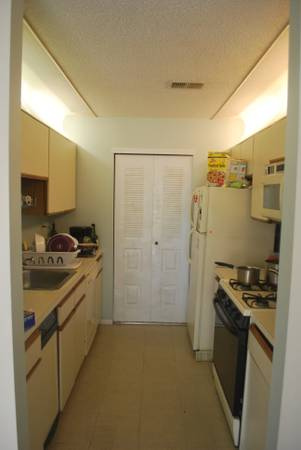

In [147]:
show_coco(img['cocoid'])

In [80]:
cap_sent

['a little girl holding a kitten next to a blue fence',
 'girl in a tank top holding a kitten in her back yard',
 'a young girl is holding a small cat',
 'girl with a yellow shirt holding a small cat',
 'a girl smiles as she holds a kitty cat']

In [127]:
sentid_to_sent = {}
imgid_to_img = {}
for image in images:
    imgid_to_img[image['cocoid']] = image
    for sent in image['sentences']:
        sentid_to_sent[sent['sentid']] = sent

In [9]:
len(sentid_to_sent)

616767

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

disabled:

vectorizer = TfidfVectorizer(analyzer=lambda x: x['tokens'])

vectorizer.fit(sentid_to_sent.values())

vectorizer.idf_

np.argmin(vectorizer.idf_)

id2str = vectorizer.get_feature_names()

id2str[568]

np.argmax(vectorizer.idf_)

id2str[3]

Length = specificity? A counter-example is breeds of dogs. We'd see this as some captions saying "dog" and others saying something else _instead of "dog"_.

In [91]:
def has_dog(sent):
    tokens = sent['tokens']
    raw = sent['raw'].lower()
    if 'hot dog' in raw or 'chili dog' in raw:
        return False
    return 'dog' in tokens or 'dogs' in tokens or 'puppy' in tokens or 'puppies' in tokens
dog_sents = {sent['sentid'] for sent in sentid_to_sent.values() if has_dog(sent)}

In [92]:
dog_images = [img for img in images if any(sent['sentid'] in dog_sents for sent in img['sentences'])]

In [93]:
len(dog_images)

4479

In [94]:
non_dog_sents = [sent for img in dog_images for sent in img['sentences'] if not has_dog(sent)]
len(non_dog_sents)

3662

40369
A cake is lit with tall yellow candles.
a person is holding a white dog and looking at a white cake
A tall, white birthday cake with a 6 candle on it sits with lit candles on a table; a dog bone has also been decorated and had a single candle lit, and a lady is holding a white dog in the background. 
A birthday cake with lit birthday candles on a table.
A 6th birthday cake for a white dog being held by its owner.


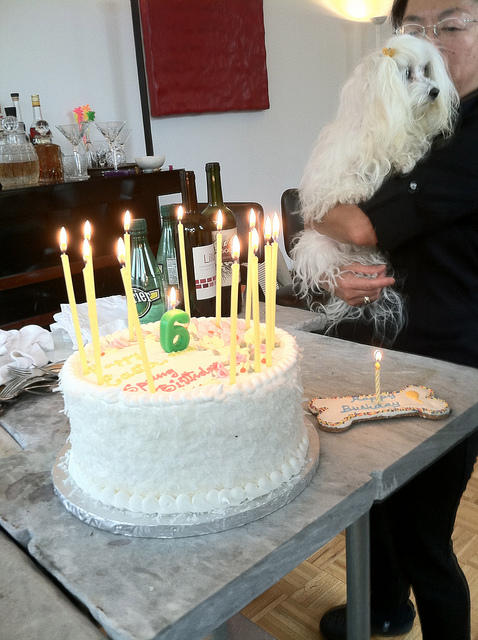

In [100]:
def show_caps(img):
    print(img['imgid'])
    print('\n'.join(sent['raw'] for sent in img['sentences']))
    cocoid = img['cocoid']
    assert cocoid is not None
    return Image(f'http://images.cocodataset.org/train2017/{cocoid:012d}.jpg')
show_caps(imgid_to_img[non_dog_sents[1125]['imgid']])

In [107]:
def any_but_not_all(seq):
    seq = list(seq)
    n = sum(1 for it in seq if it)
    return n != 0 and n != len(seq)
terriers = [
    img
    for img in images
    if any_but_not_all('terrier' in sent['tokens'] for sent in img['sentences'])
#    and not all('terrier' in sent['tokens'] for sent in img['sentences'])]
]
len(terriers)

37

2529
A small tricolor terrier dog in a pink collar.
A dog sitting  and alert looking a something.
A dog pays attention to something out of frame.
A close up view of a very cute scruffy dog.
A small dog with a collar in a room.


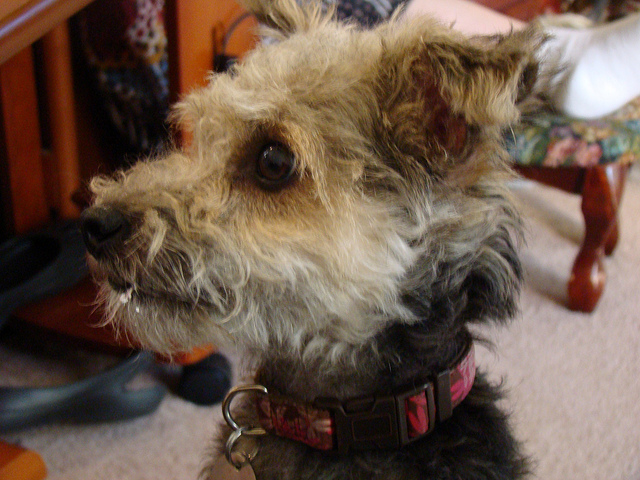

In [108]:
show_caps(terriers[2])

In [112]:
[sent for sent in sentid_to_sent.values() if 'a hot dog serves with fries and dip on the side' in sent['raw'].lower()]

[{'imgid': 63689,
  'raw': 'A hot dog serves with fries and dip on the side.',
  'sentid': 34736,
  'tokens': ['a',
   'hot',
   'dog',
   'serves',
   'with',
   'fries',
   'and',
   'dip',
   'on',
   'the',
   'side']}]

In [113]:
imgid_to_img[63689]

{'cocoid': 524377,
 'filename': 'COCO_train2014_000000524377.jpg',
 'filepath': 'train2014',
 'imgid': 63689,
 'sentences': [{'imgid': 63689,
   'raw': 'A hot dog serves with fries and dip on the side.',
   'sentid': 34736,
   'tokens': ['a',
    'hot',
    'dog',
    'serves',
    'with',
    'fries',
    'and',
    'dip',
    'on',
    'the',
    'side']},
  {'imgid': 63689,
   'raw': 'a big sausage with onions butter and vegetables on the side',
   'sentid': 39347,
   'tokens': ['a',
    'big',
    'sausage',
    'with',
    'onions',
    'butter',
    'and',
    'vegetables',
    'on',
    'the',
    'side']},
  {'imgid': 63689,
   'raw': 'A hot dog or sausage in a bun with bowl containing condiment and bacon on the side.',
   'sentid': 42677,
   'tokens': ['a',
    'hot',
    'dog',
    'or',
    'sausage',
    'in',
    'a',
    'bun',
    'with',
    'bowl',
    'containing',
    'condiment',
    'and',
    'bacon',
    'on',
    'the',
    'side']},
  {'imgid': 63689,
   'raw':

In [115]:
[sent['raw'] for sent in sentid_to_sent.values() if 'porch' in sent['raw'].lower()]

['This cat is sitting on a porch near a tire.',
 'A woman is on the phone on a porch.',
 'A dog looks out a glass door overlooking a porch.',
 'Large, colorful paper umbrellas are propped up along the porch.',
 'Cat staring at something while sitting on porch.  ',
 'A boy standing outside a porch is holding his head and hands up in the air and is ready to catch a frisbee.',
 'Plantains on a stalk sitting on a porch on a sunny day.',
 'A young boy is standing on the front porch with a tennis racket.',
 'The cat is resting on the chair on the porch of the house. ',
 'A big cat laying down in a chair on a porch.',
 'a man with a horse is standing near two people on a porch',
 'The drawing depicts a man with a horse and two people on the porch. ',
 'Shoes, a chair, and snowboard sit on a porch',
 'Small enclosed porch with snowboard and shoes next to chair.',
 'A boy sitting cross legged on a porch with a cake in front of him.',
 'A park bench in front of a porch in a green grass filled pa

The specificity of a caption is $p(img|caption)=p(caption|img)p(img)/p(caption)$. As an initial approximation, we take $p(caption|img)$ to be the IoU (Jaccard similarity) between the words in caption and the words in all captions of img.

In [16]:
sample_sents = [772707, 770337, 781998, 776154]
for sentid in sample_sents:
    print(sentid, ' '.join(sentid_to_sent[sentid]['tokens']))

772707 a man riding on the back of a motorcycle
770337 a man with a red helmet on a small moped on a dirt road
781998 a man in a red shirt and a red hat is on a motorcycle on a hill side
776154 a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains


In [17]:
max(sentid_to_sent.values(), key=lambda x: len(x['tokens']))

{'imgid': 25075,
 'raw': 'A large square concrete wall, which shows people over the rim, has inside of it a pinkish cloud of dust and a fallen bull as well as two horses, the closest of which is trotting forward with a man in western gear , who is looking back at the bull.',
 'sentid': 780253,
 'tokens': ['a',
  'large',
  'square',
  'concrete',
  'wall',
  'which',
  'shows',
  'people',
  'over',
  'the',
  'rim',
  'has',
  'inside',
  'of',
  'it',
  'a',
  'pinkish',
  'cloud',
  'of',
  'dust',
  'and',
  'a',
  'fallen',
  'bull',
  'as',
  'well',
  'as',
  'two',
  'horses',
  'the',
  'closest',
  'of',
  'which',
  'is',
  'trotting',
  'forward',
  'with',
  'a',
  'man',
  'in',
  'western',
  'gear',
  'who',
  'is',
  'looking',
  'back',
  'at',
  'the',
  'bull']}

In [12]:
count_vectorizer = CountVectorizer(analyzer=lambda image: [tok for sent in image['sentences'] for tok in sent['tokens']], min_df=5)
img_by_word = count_vectorizer.fit_transform(images)

In [ ]:
caption 

In [13]:
img_by_word[0]

(123287, 9976)

In [40]:
tfidf = TfidfTransformer().fit(img_by_word)

In [23]:
id2str = vectorizer.get_feature_names()

In [41]:
id2str[np.argmin(tfidf.idf_)]

'a'

In [42]:
id2str[np.argmax(tfidf.idf_)]

'11th'

In [43]:
[id2str[x] for x in np.argsort(tfidf.idf_)[-20:]]

['evidently',
 'loosing',
 'novels',
 'bouncy',
 'highways',
 'searches',
 'highlighting',
 'colorado',
 'torsos',
 'loungers',
 'jeff',
 'plateful',
 'hideous',
 'toronto',
 'astroturf',
 'survey',
 'herons',
 'scrunched',
 'nunchuk',
 'plows']

In [28]:
np.argmax(vectorizer.idf_)

5

In [29]:
vectorizer.idf_[5]

10.930518891587159

In [32]:
[vectorizer.idf_[x] for x in np.argsort(vectorizer.idf_)[-20:]]

[10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159,
 10.930518891587159]

Lots of ties.

In [35]:
print('\n'.join([s['raw'] for s in captions['images'][0]['sentences']]))

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


In [45]:
candidate_words = {tok for sent in captions['images'][0]['sentences'] for tok in sent['toks']}

KeyError: 'toks'

In [44]:
img_by_word

<123287x9976 sparse matrix of type '<class 'numpy.int64'>'
	with 3396630 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.feature_selection import mutual_info_classif

In [48]:
num_imgs = img_by_word.shape[0]
one_hot = np.zeros(num_imgs)
one_hot[0] = 1
#mutual_info_classif(img_by_word, one_hot, discrete_features=True)
prob_img = 1/num_imgs
prob_word = img_by_word.sum(axis=0)

KeyboardInterrupt: 